# PTN Template
This notebook serves as a template for single dataset PTN experiments  
It can be run on its own by setting STANDALONE to True (do a find for "STANDALONE" to see where)  
But it is intended to be executed as part of a *papermill.py script. See any of the   
experimentes with a papermill script to get started with that workflow.  

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Required Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "labels_source",
    "labels_target",
    "domains_source",
    "domains_target",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "n_shot",
    "n_way",
    "n_query",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_transforms_source",
    "x_transforms_target",
    "episode_transforms_source",
    "episode_transforms_target",
    "pickle_name",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "torch_default_dtype"
}

In [3]:


standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337


standalone_parameters["num_examples_per_domain_per_label_source"]=100
standalone_parameters["num_examples_per_domain_per_label_target"]=100

standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 100

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "target_accuracy"

standalone_parameters["x_transforms_source"] = ["unit_power"]
standalone_parameters["x_transforms_target"] = ["unit_power"]
standalone_parameters["episode_transforms_source"] = []
standalone_parameters["episode_transforms_target"] = []

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

# uncomment for CORES dataset
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)


standalone_parameters["labels_source"] = ALL_NODES
standalone_parameters["labels_target"] = ALL_NODES

standalone_parameters["domains_source"] = [1]
standalone_parameters["domains_target"] = [2,3,4,5]

standalone_parameters["pickle_name"] = "cores.stratified_ds.2022A.pkl"


# Uncomment these for ORACLE dataset
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )
# standalone_parameters["labels_source"] = ALL_SERIAL_NUMBERS
# standalone_parameters["labels_target"] = ALL_SERIAL_NUMBERS
# standalone_parameters["domains_source"] = [8,20, 38,50]
# standalone_parameters["domains_target"] = [14, 26, 32, 44, 56]
# standalone_parameters["pickle_name"] = "oracle.frame_indexed.stratified_ds.2022A.pkl"
# standalone_parameters["num_examples_per_domain_per_label_source"]=1000
# standalone_parameters["num_examples_per_domain_per_label_target"]=1000

# Uncomment these for Metahan dataset
# standalone_parameters["labels_source"] = list(range(19))
# standalone_parameters["labels_target"] = list(range(19))
# standalone_parameters["domains_source"] = [0]
# standalone_parameters["domains_target"] = [1]
# standalone_parameters["pickle_name"] = "metehan.stratified_ds.2022A.pkl"
# standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])
# standalone_parameters["num_examples_per_domain_per_label_source"]=200
# standalone_parameters["num_examples_per_domain_per_label_target"]=100


standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])

In [4]:
# Parameters
parameters = {
    "experiment_name": "tuned_1v2:wisig",
    "device": "cuda",
    "lr": 0.0001,
    "labels_source": [
        "1-10",
        "1-12",
        "1-14",
        "1-16",
        "1-18",
        "1-19",
        "1-8",
        "10-11",
        "10-17",
        "10-4",
        "10-7",
        "11-1",
        "11-10",
        "11-19",
        "11-20",
        "11-4",
        "11-7",
        "12-19",
        "12-20",
        "12-7",
        "13-14",
        "13-18",
        "13-19",
        "13-20",
        "13-3",
        "13-7",
        "14-10",
        "14-11",
        "14-12",
        "14-13",
        "14-14",
        "14-19",
        "14-20",
        "14-7",
        "14-8",
        "14-9",
        "15-1",
        "15-19",
        "15-6",
        "16-1",
        "16-16",
        "16-19",
        "16-20",
        "17-10",
        "17-11",
        "18-1",
        "18-10",
        "18-11",
        "18-12",
        "18-13",
        "18-14",
        "18-15",
        "18-16",
        "18-17",
        "18-19",
        "18-2",
        "18-20",
        "18-4",
        "18-5",
        "18-7",
        "18-8",
        "18-9",
        "19-1",
        "19-10",
        "19-11",
        "19-12",
        "19-13",
        "19-14",
        "19-15",
        "19-19",
        "19-2",
        "19-20",
        "19-3",
        "19-4",
        "19-6",
        "19-7",
        "19-8",
        "19-9",
        "2-1",
        "2-13",
        "2-15",
        "2-3",
        "2-4",
        "2-5",
        "2-6",
        "2-7",
        "2-8",
        "20-1",
        "20-12",
        "20-14",
        "20-15",
        "20-16",
        "20-18",
        "20-19",
        "20-20",
        "20-3",
        "20-4",
        "20-5",
        "20-7",
        "20-8",
        "3-1",
        "3-13",
        "3-18",
        "3-2",
        "3-8",
        "4-1",
        "4-10",
        "4-11",
        "5-1",
        "5-5",
        "6-1",
        "6-15",
        "6-6",
        "7-10",
        "7-11",
        "7-12",
        "7-13",
        "7-14",
        "7-7",
        "7-8",
        "7-9",
        "8-1",
        "8-13",
        "8-14",
        "8-18",
        "8-20",
        "8-3",
        "8-8",
        "9-1",
        "9-7",
    ],
    "labels_target": [
        "1-10",
        "1-12",
        "1-14",
        "1-16",
        "1-18",
        "1-19",
        "1-8",
        "10-11",
        "10-17",
        "10-4",
        "10-7",
        "11-1",
        "11-10",
        "11-19",
        "11-20",
        "11-4",
        "11-7",
        "12-19",
        "12-20",
        "12-7",
        "13-14",
        "13-18",
        "13-19",
        "13-20",
        "13-3",
        "13-7",
        "14-10",
        "14-11",
        "14-12",
        "14-13",
        "14-14",
        "14-19",
        "14-20",
        "14-7",
        "14-8",
        "14-9",
        "15-1",
        "15-19",
        "15-6",
        "16-1",
        "16-16",
        "16-19",
        "16-20",
        "17-10",
        "17-11",
        "18-1",
        "18-10",
        "18-11",
        "18-12",
        "18-13",
        "18-14",
        "18-15",
        "18-16",
        "18-17",
        "18-19",
        "18-2",
        "18-20",
        "18-4",
        "18-5",
        "18-7",
        "18-8",
        "18-9",
        "19-1",
        "19-10",
        "19-11",
        "19-12",
        "19-13",
        "19-14",
        "19-15",
        "19-19",
        "19-2",
        "19-20",
        "19-3",
        "19-4",
        "19-6",
        "19-7",
        "19-8",
        "19-9",
        "2-1",
        "2-13",
        "2-15",
        "2-3",
        "2-4",
        "2-5",
        "2-6",
        "2-7",
        "2-8",
        "20-1",
        "20-12",
        "20-14",
        "20-15",
        "20-16",
        "20-18",
        "20-19",
        "20-20",
        "20-3",
        "20-4",
        "20-5",
        "20-7",
        "20-8",
        "3-1",
        "3-13",
        "3-18",
        "3-2",
        "3-8",
        "4-1",
        "4-10",
        "4-11",
        "5-1",
        "5-5",
        "6-1",
        "6-15",
        "6-6",
        "7-10",
        "7-11",
        "7-12",
        "7-13",
        "7-14",
        "7-7",
        "7-8",
        "7-9",
        "8-1",
        "8-13",
        "8-14",
        "8-18",
        "8-20",
        "8-3",
        "8-8",
        "9-1",
        "9-7",
    ],
    "episode_transforms_source": [],
    "episode_transforms_target": [],
    "domains_source": [3],
    "domains_target": [1, 2, 4],
    "num_examples_per_domain_per_label_source": -1,
    "num_examples_per_domain_per_label_target": -1,
    "n_shot": 3,
    "n_way": 130,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "pickle_name": "wisig.node3-19.stratified_ds.2022A.pkl",
    "x_transforms_source": ["unit_power"],
    "x_transforms_target": ["unit_power"],
    "dataset_seed": 7,
    "seed": 7,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
# (This is due to the randomized initial weights)
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
###################################
# Build the dataset
###################################

if p.x_transforms_source == []: x_transform_source = None
else: x_transform_source = get_chained_transform(p.x_transforms_source) 

if p.x_transforms_target == []: x_transform_target = None
else: x_transform_target = get_chained_transform(p.x_transforms_target)

if p.episode_transforms_source == []: episode_transform_source = None
else: raise Exception("episode_transform_source not implemented")

if p.episode_transforms_target == []: episode_transform_target = None
else: raise Exception("episode_transform_target not implemented")


eaf_source = Episodic_Accessor_Factory(
    labels=p.labels_source,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_source,
    example_transform_func=episode_transform_source,
    
)
train_original_source, val_original_source, test_original_source = eaf_source.get_train(), eaf_source.get_val(), eaf_source.get_test()


eaf_target = Episodic_Accessor_Factory(
    labels=p.labels_target,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_target,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_target,
    example_transform_func=episode_transform_target,
)
train_original_target, val_original_target, test_original_target = eaf_target.get_train(), eaf_target.get_val(), eaf_target.get_test()


transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
# Some quick unit tests on the data
from steves_utils.transforms import get_average_power, get_average_magnitude

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_source))

assert q_x.dtype == eval(p.torch_default_dtype)
assert s_x.dtype == eval(p.torch_default_dtype)

print("Visually inspect these to see if they line up with expected values given the transforms")
print('x_transforms_source', p.x_transforms_source)
print('x_transforms_target', p.x_transforms_target)
print("Average magnitude, source:", get_average_magnitude(q_x[0].numpy()))
print("Average power, source:", get_average_power(q_x[0].numpy()))

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_target))
print("Average magnitude, target:", get_average_magnitude(q_x[0].numpy()))
print("Average power, target:", get_average_power(q_x[0].numpy()))


Visually inspect these to see if they line up with expected values given the transforms
x_transforms_source ['unit_power']
x_transforms_target ['unit_power']
Average magnitude, source: 0.8791374
Average power, source: 1.0


Average magnitude, target: 0.9112751
Average power, target: 1.0


In [12]:
###################################
# Build the model
###################################
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=(2,256))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [13]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 45], examples_per_second: 1954.9322, train_label_loss: 4.7056, 


epoch: 1, [batch: 5 / 45], examples_per_second: 3902.9070, train_label_loss: 4.0895, 


epoch: 1, [batch: 9 / 45], examples_per_second: 3999.0562, train_label_loss: 3.4904, 


epoch: 1, [batch: 14 / 45], examples_per_second: 4002.0704, train_label_loss: 2.8133, 


epoch: 1, [batch: 18 / 45], examples_per_second: 4005.7870, train_label_loss: 2.5676, 


epoch: 1, [batch: 23 / 45], examples_per_second: 3954.5110, train_label_loss: 2.1522, 


epoch: 1, [batch: 27 / 45], examples_per_second: 4058.9943, train_label_loss: 1.7946, 


epoch: 1, [batch: 31 / 45], examples_per_second: 4050.6884, train_label_loss: 1.6499, 


epoch: 1, [batch: 36 / 45], examples_per_second: 4093.9936, train_label_loss: 1.5790, 


epoch: 1, [batch: 40 / 45], examples_per_second: 4144.1486, train_label_loss: 1.6572, 


epoch: 1, source_val_acc_label: 0.7808, target_val_acc_label: 0.7299, source_val_label_loss: 1.3059, target_val_label_loss: 1.5485, 


New best


epoch: 2, [batch: 1 / 45], examples_per_second: 496.2864, train_label_loss: 1.3033, 


epoch: 2, [batch: 5 / 45], examples_per_second: 3974.1875, train_label_loss: 1.0994, 


epoch: 2, [batch: 9 / 45], examples_per_second: 4073.2380, train_label_loss: 1.1523, 


epoch: 2, [batch: 14 / 45], examples_per_second: 4076.0740, train_label_loss: 1.1892, 


epoch: 2, [batch: 18 / 45], examples_per_second: 4080.3966, train_label_loss: 1.3430, 


epoch: 2, [batch: 23 / 45], examples_per_second: 4031.4472, train_label_loss: 1.0632, 


epoch: 2, [batch: 27 / 45], examples_per_second: 4130.1282, train_label_loss: 0.9832, 


epoch: 2, [batch: 31 / 45], examples_per_second: 4128.4051, train_label_loss: 1.0246, 


epoch: 2, [batch: 36 / 45], examples_per_second: 4156.4027, train_label_loss: 0.9818, 


epoch: 2, [batch: 40 / 45], examples_per_second: 4226.5591, train_label_loss: 0.9857, 


epoch: 2, source_val_acc_label: 0.8590, target_val_acc_label: 0.7872, source_val_label_loss: 0.7803, target_val_label_loss: 1.0984, 


New best


epoch: 3, [batch: 1 / 45], examples_per_second: 489.4974, train_label_loss: 0.6734, 


epoch: 3, [batch: 5 / 45], examples_per_second: 3985.7132, train_label_loss: 0.8116, 


epoch: 3, [batch: 9 / 45], examples_per_second: 4074.0856, train_label_loss: 0.8188, 


epoch: 3, [batch: 14 / 45], examples_per_second: 4070.9286, train_label_loss: 0.7016, 


epoch: 3, [batch: 18 / 45], examples_per_second: 4091.3668, train_label_loss: 0.6254, 


epoch: 3, [batch: 23 / 45], examples_per_second: 4040.6583, train_label_loss: 0.7654, 


epoch: 3, [batch: 27 / 45], examples_per_second: 4130.7352, train_label_loss: 0.7402, 


epoch: 3, [batch: 31 / 45], examples_per_second: 4142.8435, train_label_loss: 0.4111, 


epoch: 3, [batch: 36 / 45], examples_per_second: 4166.0912, train_label_loss: 0.5351, 


epoch: 3, [batch: 40 / 45], examples_per_second: 4221.2633, train_label_loss: 0.6195, 


epoch: 3, source_val_acc_label: 0.8968, target_val_acc_label: 0.8120, source_val_label_loss: 0.5837, target_val_label_loss: 0.9680, 


New best


epoch: 4, [batch: 1 / 45], examples_per_second: 488.2138, train_label_loss: 0.7611, 


epoch: 4, [batch: 5 / 45], examples_per_second: 3980.9743, train_label_loss: 0.5472, 


epoch: 4, [batch: 9 / 45], examples_per_second: 4075.3295, train_label_loss: 0.6146, 


epoch: 4, [batch: 14 / 45], examples_per_second: 4081.5735, train_label_loss: 0.6522, 


epoch: 4, [batch: 18 / 45], examples_per_second: 4087.2587, train_label_loss: 0.4943, 


epoch: 4, [batch: 23 / 45], examples_per_second: 4019.3118, train_label_loss: 0.6968, 


epoch: 4, [batch: 27 / 45], examples_per_second: 4132.6606, train_label_loss: 0.5164, 


epoch: 4, [batch: 31 / 45], examples_per_second: 4134.8261, train_label_loss: 0.4503, 


epoch: 4, [batch: 36 / 45], examples_per_second: 4163.2818, train_label_loss: 0.3697, 


epoch: 4, [batch: 40 / 45], examples_per_second: 4228.4077, train_label_loss: 0.3875, 


epoch: 4, source_val_acc_label: 0.9179, target_val_acc_label: 0.8325, source_val_label_loss: 0.4468, target_val_label_loss: 0.8657, 


New best


epoch: 5, [batch: 1 / 45], examples_per_second: 487.3468, train_label_loss: 0.5479, 


epoch: 5, [batch: 5 / 45], examples_per_second: 3964.1169, train_label_loss: 0.4636, 


epoch: 5, [batch: 9 / 45], examples_per_second: 4074.5772, train_label_loss: 0.3035, 


epoch: 5, [batch: 14 / 45], examples_per_second: 4079.6532, train_label_loss: 0.4162, 


epoch: 5, [batch: 18 / 45], examples_per_second: 4086.7502, train_label_loss: 0.4773, 


epoch: 5, [batch: 23 / 45], examples_per_second: 4015.3018, train_label_loss: 0.3393, 


epoch: 5, [batch: 27 / 45], examples_per_second: 4125.9232, train_label_loss: 0.2872, 


epoch: 5, [batch: 31 / 45], examples_per_second: 4128.9929, train_label_loss: 0.2899, 


epoch: 5, [batch: 36 / 45], examples_per_second: 4159.7118, train_label_loss: 0.5661, 


epoch: 5, [batch: 40 / 45], examples_per_second: 4222.5284, train_label_loss: 0.3313, 


epoch: 5, source_val_acc_label: 0.9417, target_val_acc_label: 0.8474, source_val_label_loss: 0.3454, target_val_label_loss: 0.7930, 


New best


epoch: 6, [batch: 1 / 45], examples_per_second: 490.4848, train_label_loss: 0.3685, 


epoch: 6, [batch: 5 / 45], examples_per_second: 3956.2920, train_label_loss: 0.2571, 


epoch: 6, [batch: 9 / 45], examples_per_second: 4068.9142, train_label_loss: 0.2521, 


epoch: 6, [batch: 14 / 45], examples_per_second: 4089.9597, train_label_loss: 0.2969, 


epoch: 6, [batch: 18 / 45], examples_per_second: 4078.1947, train_label_loss: 0.2803, 


epoch: 6, [batch: 23 / 45], examples_per_second: 4021.1247, train_label_loss: 0.3569, 


epoch: 6, [batch: 27 / 45], examples_per_second: 4136.0493, train_label_loss: 0.3784, 


epoch: 6, [batch: 31 / 45], examples_per_second: 4134.6004, train_label_loss: 0.3760, 


epoch: 6, [batch: 36 / 45], examples_per_second: 4159.7436, train_label_loss: 0.3461, 


epoch: 6, [batch: 40 / 45], examples_per_second: 4218.5558, train_label_loss: 0.2021, 


epoch: 6, source_val_acc_label: 0.9474, target_val_acc_label: 0.8590, source_val_label_loss: 0.3044, target_val_label_loss: 0.7501, 


New best


epoch: 7, [batch: 1 / 45], examples_per_second: 486.4023, train_label_loss: 0.2953, 


epoch: 7, [batch: 5 / 45], examples_per_second: 3964.4959, train_label_loss: 0.1283, 


epoch: 7, [batch: 9 / 45], examples_per_second: 4074.4981, train_label_loss: 0.3369, 


epoch: 7, [batch: 14 / 45], examples_per_second: 4075.4001, train_label_loss: 0.1340, 


epoch: 7, [batch: 18 / 45], examples_per_second: 4074.1632, train_label_loss: 0.2839, 


epoch: 7, [batch: 23 / 45], examples_per_second: 4021.8152, train_label_loss: 0.1988, 


epoch: 7, [batch: 27 / 45], examples_per_second: 4117.6181, train_label_loss: 0.1917, 


epoch: 7, [batch: 31 / 45], examples_per_second: 4114.9752, train_label_loss: 0.2253, 


epoch: 7, [batch: 36 / 45], examples_per_second: 4159.0316, train_label_loss: 0.1997, 


epoch: 7, [batch: 40 / 45], examples_per_second: 4212.8926, train_label_loss: 0.2454, 


epoch: 7, source_val_acc_label: 0.9564, target_val_acc_label: 0.8596, source_val_label_loss: 0.2691, target_val_label_loss: 0.7266, 


New best


epoch: 8, [batch: 1 / 45], examples_per_second: 485.4514, train_label_loss: 0.1424, 


epoch: 8, [batch: 5 / 45], examples_per_second: 3954.2033, train_label_loss: 0.1998, 


epoch: 8, [batch: 9 / 45], examples_per_second: 4069.2087, train_label_loss: 0.3237, 


epoch: 8, [batch: 14 / 45], examples_per_second: 4066.2121, train_label_loss: 0.1985, 


epoch: 8, [batch: 18 / 45], examples_per_second: 4064.7025, train_label_loss: 0.2760, 


epoch: 8, [batch: 23 / 45], examples_per_second: 4005.5290, train_label_loss: 0.3216, 


epoch: 8, [batch: 27 / 45], examples_per_second: 4108.9733, train_label_loss: 0.2520, 


epoch: 8, [batch: 31 / 45], examples_per_second: 4112.5822, train_label_loss: 0.1735, 


epoch: 8, [batch: 36 / 45], examples_per_second: 4153.6848, train_label_loss: 0.2592, 


epoch: 8, [batch: 40 / 45], examples_per_second: 4209.0096, train_label_loss: 0.1253, 


epoch: 8, source_val_acc_label: 0.9558, target_val_acc_label: 0.8656, source_val_label_loss: 0.2544, target_val_label_loss: 0.7192, 


New best


epoch: 9, [batch: 1 / 45], examples_per_second: 489.1985, train_label_loss: 0.1913, 


epoch: 9, [batch: 5 / 45], examples_per_second: 3972.5936, train_label_loss: 0.1399, 


epoch: 9, [batch: 9 / 45], examples_per_second: 4081.4412, train_label_loss: 0.3323, 


epoch: 9, [batch: 14 / 45], examples_per_second: 4077.6347, train_label_loss: 0.1733, 


epoch: 9, [batch: 18 / 45], examples_per_second: 4064.0481, train_label_loss: 0.1819, 


epoch: 9, [batch: 23 / 45], examples_per_second: 4016.1004, train_label_loss: 0.1915, 


epoch: 9, [batch: 27 / 45], examples_per_second: 4126.2448, train_label_loss: 0.2640, 


epoch: 9, [batch: 31 / 45], examples_per_second: 4121.2999, train_label_loss: 0.2202, 


epoch: 9, [batch: 36 / 45], examples_per_second: 4149.6626, train_label_loss: 0.2681, 


epoch: 9, [batch: 40 / 45], examples_per_second: 4214.9801, train_label_loss: 0.1326, 


epoch: 9, source_val_acc_label: 0.9571, target_val_acc_label: 0.8684, source_val_label_loss: 0.2551, target_val_label_loss: 0.7051, 


New best


epoch: 10, [batch: 1 / 45], examples_per_second: 489.0990, train_label_loss: 0.1391, 


epoch: 10, [batch: 5 / 45], examples_per_second: 3975.6914, train_label_loss: 0.2272, 


epoch: 10, [batch: 9 / 45], examples_per_second: 4067.4527, train_label_loss: 0.1102, 


epoch: 10, [batch: 14 / 45], examples_per_second: 4055.8305, train_label_loss: 0.1341, 


epoch: 10, [batch: 18 / 45], examples_per_second: 4057.9521, train_label_loss: 0.2451, 


epoch: 10, [batch: 23 / 45], examples_per_second: 4003.0788, train_label_loss: 0.1089, 


epoch: 10, [batch: 27 / 45], examples_per_second: 4107.7939, train_label_loss: 0.1401, 


epoch: 10, [batch: 31 / 45], examples_per_second: 4110.9528, train_label_loss: 0.1740, 


epoch: 10, [batch: 36 / 45], examples_per_second: 4156.8692, train_label_loss: 0.0914, 


epoch: 10, [batch: 40 / 45], examples_per_second: 4211.5454, train_label_loss: 0.1931, 


epoch: 10, source_val_acc_label: 0.9596, target_val_acc_label: 0.8737, source_val_label_loss: 0.2318, target_val_label_loss: 0.6787, 


New best


epoch: 11, [batch: 1 / 45], examples_per_second: 491.4969, train_label_loss: 0.3204, 


epoch: 11, [batch: 5 / 45], examples_per_second: 3965.9146, train_label_loss: 0.1587, 


epoch: 11, [batch: 9 / 45], examples_per_second: 4066.7716, train_label_loss: 0.1564, 


epoch: 11, [batch: 14 / 45], examples_per_second: 4066.6391, train_label_loss: 0.1223, 


epoch: 11, [batch: 18 / 45], examples_per_second: 4068.9445, train_label_loss: 0.2349, 


epoch: 11, [batch: 23 / 45], examples_per_second: 4013.5498, train_label_loss: 0.1443, 


epoch: 11, [batch: 27 / 45], examples_per_second: 4118.9961, train_label_loss: 0.2125, 


epoch: 11, [batch: 31 / 45], examples_per_second: 4116.9108, train_label_loss: 0.1532, 


epoch: 11, [batch: 36 / 45], examples_per_second: 4152.6940, train_label_loss: 0.1869, 


epoch: 11, [batch: 40 / 45], examples_per_second: 4214.5826, train_label_loss: 0.1567, 


epoch: 11, source_val_acc_label: 0.9577, target_val_acc_label: 0.8720, source_val_label_loss: 0.2252, target_val_label_loss: 0.6699, 


epoch: 12, [batch: 1 / 45], examples_per_second: 502.4357, train_label_loss: 0.1126, 


epoch: 12, [batch: 5 / 45], examples_per_second: 3967.1380, train_label_loss: 0.1565, 


epoch: 12, [batch: 9 / 45], examples_per_second: 4051.9466, train_label_loss: 0.1666, 


epoch: 12, [batch: 14 / 45], examples_per_second: 4071.5803, train_label_loss: 0.1448, 


epoch: 12, [batch: 18 / 45], examples_per_second: 4066.8702, train_label_loss: 0.1232, 


epoch: 12, [batch: 23 / 45], examples_per_second: 4010.9234, train_label_loss: 0.0937, 


epoch: 12, [batch: 27 / 45], examples_per_second: 4110.1224, train_label_loss: 0.1078, 


epoch: 12, [batch: 31 / 45], examples_per_second: 4120.1601, train_label_loss: 0.0544, 


epoch: 12, [batch: 36 / 45], examples_per_second: 4147.5641, train_label_loss: 0.0958, 


epoch: 12, [batch: 40 / 45], examples_per_second: 4202.8163, train_label_loss: 0.1916, 


epoch: 12, source_val_acc_label: 0.9571, target_val_acc_label: 0.8667, source_val_label_loss: 0.2319, target_val_label_loss: 0.6799, 


epoch: 13, [batch: 1 / 45], examples_per_second: 500.4309, train_label_loss: 0.1233, 


epoch: 13, [batch: 5 / 45], examples_per_second: 3962.7484, train_label_loss: 0.1182, 


epoch: 13, [batch: 9 / 45], examples_per_second: 4057.1354, train_label_loss: 0.1126, 


epoch: 13, [batch: 14 / 45], examples_per_second: 4020.2838, train_label_loss: 0.1670, 


epoch: 13, [batch: 18 / 45], examples_per_second: 4065.9953, train_label_loss: 0.2534, 


epoch: 13, [batch: 23 / 45], examples_per_second: 4014.9104, train_label_loss: 0.1159, 


epoch: 13, [batch: 27 / 45], examples_per_second: 4111.2055, train_label_loss: 0.1255, 


epoch: 13, [batch: 31 / 45], examples_per_second: 4128.0223, train_label_loss: 0.0843, 


epoch: 13, [batch: 36 / 45], examples_per_second: 4158.2615, train_label_loss: 0.0556, 


epoch: 13, [batch: 40 / 45], examples_per_second: 4207.3549, train_label_loss: 0.2468, 


epoch: 13, source_val_acc_label: 0.9628, target_val_acc_label: 0.8705, source_val_label_loss: 0.2173, target_val_label_loss: 0.6626, 


epoch: 14, [batch: 1 / 45], examples_per_second: 503.7595, train_label_loss: 0.1496, 


epoch: 14, [batch: 5 / 45], examples_per_second: 3973.5894, train_label_loss: 0.1268, 


epoch: 14, [batch: 9 / 45], examples_per_second: 4055.0746, train_label_loss: 0.1145, 


epoch: 14, [batch: 14 / 45], examples_per_second: 4054.5445, train_label_loss: 0.1146, 


epoch: 14, [batch: 18 / 45], examples_per_second: 4035.9474, train_label_loss: 0.1038, 


epoch: 14, [batch: 23 / 45], examples_per_second: 4017.6687, train_label_loss: 0.1500, 


epoch: 14, [batch: 27 / 45], examples_per_second: 4123.5175, train_label_loss: 0.1295, 


epoch: 14, [batch: 31 / 45], examples_per_second: 4115.2687, train_label_loss: 0.1980, 


epoch: 14, [batch: 36 / 45], examples_per_second: 4149.5097, train_label_loss: 0.1195, 


epoch: 14, [batch: 40 / 45], examples_per_second: 4190.5551, train_label_loss: 0.0400, 


epoch: 14, source_val_acc_label: 0.9635, target_val_acc_label: 0.8750, source_val_label_loss: 0.2179, target_val_label_loss: 0.6633, 


New best


epoch: 15, [batch: 1 / 45], examples_per_second: 486.9885, train_label_loss: 0.1255, 


epoch: 15, [batch: 5 / 45], examples_per_second: 3949.3244, train_label_loss: 0.2201, 


epoch: 15, [batch: 9 / 45], examples_per_second: 4048.2779, train_label_loss: 0.0907, 


epoch: 15, [batch: 14 / 45], examples_per_second: 4052.3086, train_label_loss: 0.1005, 


epoch: 15, [batch: 18 / 45], examples_per_second: 4054.9494, train_label_loss: 0.0807, 


epoch: 15, [batch: 23 / 45], examples_per_second: 4004.1688, train_label_loss: 0.2007, 


epoch: 15, [batch: 27 / 45], examples_per_second: 4111.8674, train_label_loss: 0.0874, 


epoch: 15, [batch: 31 / 45], examples_per_second: 4111.2783, train_label_loss: 0.0737, 


epoch: 15, [batch: 36 / 45], examples_per_second: 4154.6862, train_label_loss: 0.0608, 


epoch: 15, [batch: 40 / 45], examples_per_second: 4212.8128, train_label_loss: 0.0832, 


epoch: 15, source_val_acc_label: 0.9667, target_val_acc_label: 0.8756, source_val_label_loss: 0.2081, target_val_label_loss: 0.6517, 


New best


epoch: 16, [batch: 1 / 45], examples_per_second: 488.6975, train_label_loss: 0.0674, 


epoch: 16, [batch: 5 / 45], examples_per_second: 3961.0356, train_label_loss: 0.0903, 


epoch: 16, [batch: 9 / 45], examples_per_second: 4063.2108, train_label_loss: 0.1769, 


epoch: 16, [batch: 14 / 45], examples_per_second: 4072.2712, train_label_loss: 0.0957, 


epoch: 16, [batch: 18 / 45], examples_per_second: 4054.1203, train_label_loss: 0.1564, 


epoch: 16, [batch: 23 / 45], examples_per_second: 4004.2335, train_label_loss: 0.1554, 


epoch: 16, [batch: 27 / 45], examples_per_second: 4115.1879, train_label_loss: 0.1120, 


epoch: 16, [batch: 31 / 45], examples_per_second: 4114.0375, train_label_loss: 0.0999, 


epoch: 16, [batch: 36 / 45], examples_per_second: 4153.9531, train_label_loss: 0.0552, 


epoch: 16, [batch: 40 / 45], examples_per_second: 4199.2236, train_label_loss: 0.0517, 


epoch: 16, source_val_acc_label: 0.9654, target_val_acc_label: 0.8799, source_val_label_loss: 0.2027, target_val_label_loss: 0.6515, 


New best


epoch: 17, [batch: 1 / 45], examples_per_second: 487.6757, train_label_loss: 0.0676, 


epoch: 17, [batch: 5 / 45], examples_per_second: 3961.8774, train_label_loss: 0.1728, 


epoch: 17, [batch: 9 / 45], examples_per_second: 4055.6145, train_label_loss: 0.0997, 


epoch: 17, [batch: 14 / 45], examples_per_second: 4072.3089, train_label_loss: 0.1417, 


epoch: 17, [batch: 18 / 45], examples_per_second: 4061.4266, train_label_loss: 0.1738, 


epoch: 17, [batch: 23 / 45], examples_per_second: 4011.4746, train_label_loss: 0.0502, 


epoch: 17, [batch: 27 / 45], examples_per_second: 4122.1754, train_label_loss: 0.0233, 


epoch: 17, [batch: 31 / 45], examples_per_second: 4126.3822, train_label_loss: 0.0479, 


epoch: 17, [batch: 36 / 45], examples_per_second: 4149.3253, train_label_loss: 0.1277, 


epoch: 17, [batch: 40 / 45], examples_per_second: 4210.5828, train_label_loss: 0.0827, 


epoch: 17, source_val_acc_label: 0.9647, target_val_acc_label: 0.8754, source_val_label_loss: 0.1997, target_val_label_loss: 0.6583, 


epoch: 18, [batch: 1 / 45], examples_per_second: 500.2369, train_label_loss: 0.1861, 


epoch: 18, [batch: 5 / 45], examples_per_second: 3953.6657, train_label_loss: 0.0599, 


epoch: 18, [batch: 9 / 45], examples_per_second: 4026.2811, train_label_loss: 0.0315, 


epoch: 18, [batch: 14 / 45], examples_per_second: 4061.2536, train_label_loss: 0.1002, 


epoch: 18, [batch: 18 / 45], examples_per_second: 4055.6642, train_label_loss: 0.0460, 


epoch: 18, [batch: 23 / 45], examples_per_second: 4001.7919, train_label_loss: 0.1446, 


epoch: 18, [batch: 27 / 45], examples_per_second: 4109.5214, train_label_loss: 0.1235, 


epoch: 18, [batch: 31 / 45], examples_per_second: 4107.0853, train_label_loss: 0.1081, 


epoch: 18, [batch: 36 / 45], examples_per_second: 4146.1815, train_label_loss: 0.1065, 


epoch: 18, [batch: 40 / 45], examples_per_second: 4205.7404, train_label_loss: 0.0750, 


epoch: 18, source_val_acc_label: 0.9615, target_val_acc_label: 0.8801, source_val_label_loss: 0.2199, target_val_label_loss: 0.6608, 


New best


epoch: 19, [batch: 1 / 45], examples_per_second: 489.3862, train_label_loss: 0.0524, 


epoch: 19, [batch: 5 / 45], examples_per_second: 3953.4034, train_label_loss: 0.0680, 


epoch: 19, [batch: 9 / 45], examples_per_second: 4061.2512, train_label_loss: 0.0654, 


epoch: 19, [batch: 14 / 45], examples_per_second: 4068.6042, train_label_loss: 0.0578, 


epoch: 19, [batch: 18 / 45], examples_per_second: 4072.1064, train_label_loss: 0.0561, 


epoch: 19, [batch: 23 / 45], examples_per_second: 4000.1491, train_label_loss: 0.0175, 


epoch: 19, [batch: 27 / 45], examples_per_second: 4114.7904, train_label_loss: 0.1396, 


epoch: 19, [batch: 31 / 45], examples_per_second: 4116.6715, train_label_loss: 0.0264, 


epoch: 19, [batch: 36 / 45], examples_per_second: 4155.6716, train_label_loss: 0.1561, 


epoch: 19, [batch: 40 / 45], examples_per_second: 4203.4092, train_label_loss: 0.0493, 


epoch: 19, source_val_acc_label: 0.9628, target_val_acc_label: 0.8752, source_val_label_loss: 0.2155, target_val_label_loss: 0.6680, 


epoch: 20, [batch: 1 / 45], examples_per_second: 503.8244, train_label_loss: 0.0428, 


epoch: 20, [batch: 5 / 45], examples_per_second: 3961.4126, train_label_loss: 0.0941, 


epoch: 20, [batch: 9 / 45], examples_per_second: 4051.2783, train_label_loss: 0.0209, 


epoch: 20, [batch: 14 / 45], examples_per_second: 4076.7323, train_label_loss: 0.0785, 


epoch: 20, [batch: 18 / 45], examples_per_second: 4065.2995, train_label_loss: 0.0422, 


epoch: 20, [batch: 23 / 45], examples_per_second: 4005.7503, train_label_loss: 0.0363, 


epoch: 20, [batch: 27 / 45], examples_per_second: 4120.4326, train_label_loss: 0.2072, 


epoch: 20, [batch: 31 / 45], examples_per_second: 4117.2481, train_label_loss: 0.0590, 


epoch: 20, [batch: 36 / 45], examples_per_second: 4154.6115, train_label_loss: 0.0995, 


epoch: 20, [batch: 40 / 45], examples_per_second: 4212.1327, train_label_loss: 0.0198, 


epoch: 20, source_val_acc_label: 0.9635, target_val_acc_label: 0.8850, source_val_label_loss: 0.2003, target_val_label_loss: 0.6429, 


New best


epoch: 21, [batch: 1 / 45], examples_per_second: 489.8511, train_label_loss: 0.0685, 


epoch: 21, [batch: 5 / 45], examples_per_second: 3964.7496, train_label_loss: 0.0610, 


epoch: 21, [batch: 9 / 45], examples_per_second: 4061.3132, train_label_loss: 0.1879, 


epoch: 21, [batch: 14 / 45], examples_per_second: 4046.0433, train_label_loss: 0.0695, 


epoch: 21, [batch: 18 / 45], examples_per_second: 4041.5984, train_label_loss: 0.0544, 


epoch: 21, [batch: 23 / 45], examples_per_second: 4006.9230, train_label_loss: 0.0389, 


epoch: 21, [batch: 27 / 45], examples_per_second: 4116.7026, train_label_loss: 0.1619, 


epoch: 21, [batch: 31 / 45], examples_per_second: 4120.1539, train_label_loss: 0.0254, 


epoch: 21, [batch: 36 / 45], examples_per_second: 4150.8478, train_label_loss: 0.0670, 


epoch: 21, [batch: 40 / 45], examples_per_second: 4208.9365, train_label_loss: 0.0968, 


epoch: 21, source_val_acc_label: 0.9609, target_val_acc_label: 0.8816, source_val_label_loss: 0.2196, target_val_label_loss: 0.6509, 


epoch: 22, [batch: 1 / 45], examples_per_second: 502.4987, train_label_loss: 0.0849, 


epoch: 22, [batch: 5 / 45], examples_per_second: 3963.7682, train_label_loss: 0.0792, 


epoch: 22, [batch: 9 / 45], examples_per_second: 4049.3964, train_label_loss: 0.1138, 


epoch: 22, [batch: 14 / 45], examples_per_second: 4046.2414, train_label_loss: 0.0752, 


epoch: 22, [batch: 18 / 45], examples_per_second: 4055.3566, train_label_loss: 0.0552, 


epoch: 22, [batch: 23 / 45], examples_per_second: 4002.5416, train_label_loss: 0.1124, 


epoch: 22, [batch: 27 / 45], examples_per_second: 4117.2528, train_label_loss: 0.1737, 


epoch: 22, [batch: 31 / 45], examples_per_second: 4089.2419, train_label_loss: 0.0797, 


epoch: 22, [batch: 36 / 45], examples_per_second: 4148.9616, train_label_loss: 0.1002, 


epoch: 22, [batch: 40 / 45], examples_per_second: 4198.7983, train_label_loss: 0.0577, 


epoch: 22, source_val_acc_label: 0.9660, target_val_acc_label: 0.8756, source_val_label_loss: 0.2106, target_val_label_loss: 0.6629, 


epoch: 23, [batch: 1 / 45], examples_per_second: 503.0412, train_label_loss: 0.0943, 


epoch: 23, [batch: 5 / 45], examples_per_second: 3975.8741, train_label_loss: 0.0804, 


epoch: 23, [batch: 9 / 45], examples_per_second: 4056.6222, train_label_loss: 0.0717, 


epoch: 23, [batch: 14 / 45], examples_per_second: 4049.2367, train_label_loss: 0.0534, 


epoch: 23, [batch: 18 / 45], examples_per_second: 4037.3295, train_label_loss: 0.0763, 


epoch: 23, [batch: 23 / 45], examples_per_second: 3996.4514, train_label_loss: 0.1348, 


epoch: 23, [batch: 27 / 45], examples_per_second: 4105.5947, train_label_loss: 0.0580, 


epoch: 23, [batch: 31 / 45], examples_per_second: 4106.9291, train_label_loss: 0.0172, 


epoch: 23, [batch: 36 / 45], examples_per_second: 4129.6089, train_label_loss: 0.0377, 


epoch: 23, [batch: 40 / 45], examples_per_second: 4210.8559, train_label_loss: 0.1242, 


epoch: 23, source_val_acc_label: 0.9609, target_val_acc_label: 0.8786, source_val_label_loss: 0.2191, target_val_label_loss: 0.6615, 


epoch: 24, [batch: 1 / 45], examples_per_second: 504.8736, train_label_loss: 0.0618, 


epoch: 24, [batch: 5 / 45], examples_per_second: 3958.1142, train_label_loss: 0.0896, 


epoch: 24, [batch: 9 / 45], examples_per_second: 4057.6154, train_label_loss: 0.1402, 


epoch: 24, [batch: 14 / 45], examples_per_second: 4060.0004, train_label_loss: 0.1175, 


epoch: 24, [batch: 18 / 45], examples_per_second: 4048.0150, train_label_loss: 0.0798, 


epoch: 24, [batch: 23 / 45], examples_per_second: 4013.3761, train_label_loss: 0.0724, 


epoch: 24, [batch: 27 / 45], examples_per_second: 4113.8001, train_label_loss: 0.0990, 


epoch: 24, [batch: 31 / 45], examples_per_second: 4108.0120, train_label_loss: 0.0819, 


epoch: 24, [batch: 36 / 45], examples_per_second: 4156.1632, train_label_loss: 0.0874, 


epoch: 24, [batch: 40 / 45], examples_per_second: 4210.7876, train_label_loss: 0.0986, 


epoch: 24, source_val_acc_label: 0.9641, target_val_acc_label: 0.8833, source_val_label_loss: 0.1933, target_val_label_loss: 0.6471, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

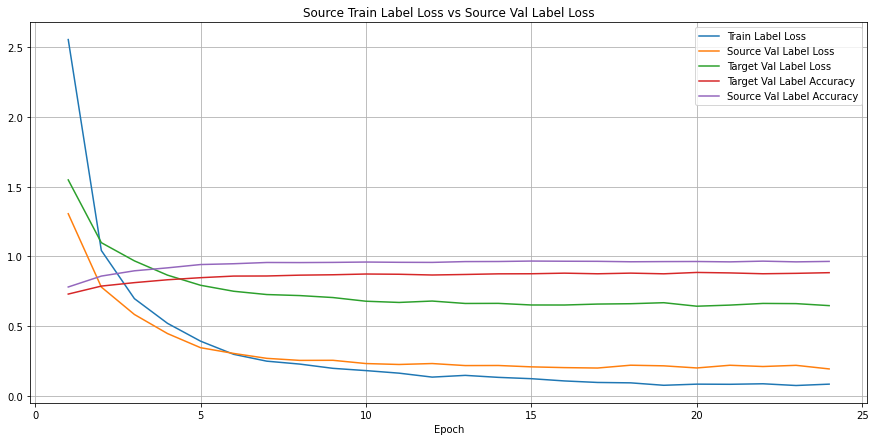

In [16]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

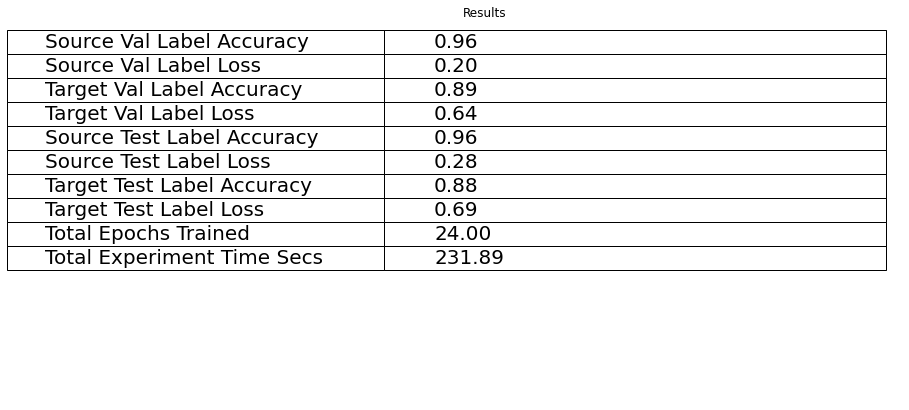

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

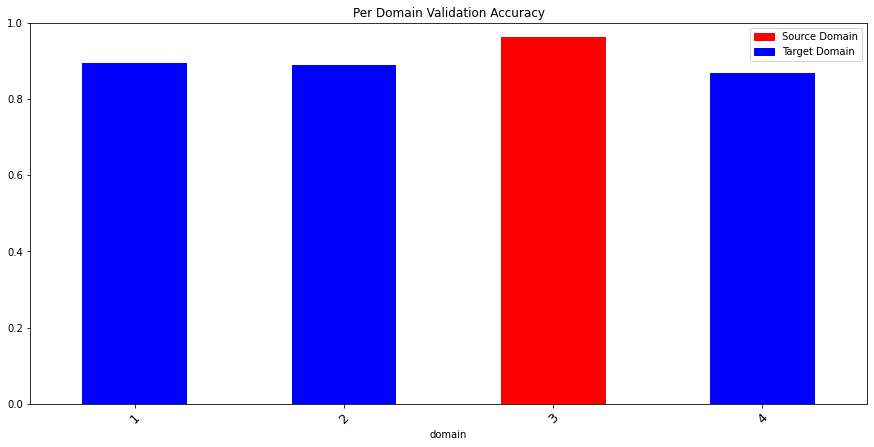

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9596153846153846 Target Test Label Accuracy: 0.8771367521367521
Source Val Label Accuracy: 0.9634615384615385 Target Val Label Accuracy: 0.885042735042735


In [20]:
json.dumps(experiment)

'{"experiment_name": "tuned_1v2:wisig", "parameters": {"experiment_name": "tuned_1v2:wisig", "device": "cuda", "lr": 0.0001, "labels_source": ["1-10", "1-12", "1-14", "1-16", "1-18", "1-19", "1-8", "10-11", "10-17", "10-4", "10-7", "11-1", "11-10", "11-19", "11-20", "11-4", "11-7", "12-19", "12-20", "12-7", "13-14", "13-18", "13-19", "13-20", "13-3", "13-7", "14-10", "14-11", "14-12", "14-13", "14-14", "14-19", "14-20", "14-7", "14-8", "14-9", "15-1", "15-19", "15-6", "16-1", "16-16", "16-19", "16-20", "17-10", "17-11", "18-1", "18-10", "18-11", "18-12", "18-13", "18-14", "18-15", "18-16", "18-17", "18-19", "18-2", "18-20", "18-4", "18-5", "18-7", "18-8", "18-9", "19-1", "19-10", "19-11", "19-12", "19-13", "19-14", "19-15", "19-19", "19-2", "19-20", "19-3", "19-4", "19-6", "19-7", "19-8", "19-9", "2-1", "2-13", "2-15", "2-3", "2-4", "2-5", "2-6", "2-7", "2-8", "20-1", "20-12", "20-14", "20-15", "20-16", "20-18", "20-19", "20-20", "20-3", "20-4", "20-5", "20-7", "20-8", "3-1", "3-13", "